In [30]:
from scipy.optimize import minimize, brute
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
currentdir = os.getcwd()

In [31]:
data = pd.read_csv(currentdir+'/data/poland_eup.csv')
data.dropna(inplace=True)
data = data.sort_values(by='year', ascending=True)
data = data.reset_index(drop=True)
data

,year,"unemployed, thousands","prisoners, thousands","employed, thousands"
0,2008,1813.4,85.9,14037.2
1,2009,1634.4,85.4,13782.3
2,2010,2052.5,82.9,14640.0
3,2011,2105.0,82.6,14821.0
4,2012,2121.5,84.3,14924.0
5,2013,2295.7,83.9,14861.0
6,2014,2260.7,79.0,15140.0
7,2015,1918.6,74.8,15451.0
8,2016,1647.5,71.6,15708.0
9,2017,1397.1,72.0,16045.0


In [32]:
params = (6.51826215e-02,  1.17101395e-03, -4.89964539e-03, -2.24443190e-04,
        1.69655460e-03,  4.16971862e-03,  1.07993439e+02)

# grid of years

t = np.linspace(2008, 2022, 15)

# Initial vector

E0, U0, P0 = data['employed, thousands'].iloc[0], data['unemployed, thousands'].iloc[0], data['prisoners, thousands'].iloc[0]

y0 = E0, U0, P0

In [33]:
y_true = (data['employed, thousands'], data['unemployed, thousands'], data['prisoners, thousands'])

In [34]:
slice(0, 1, 0.01)

slice(0, 1, 0.01)

In [35]:
rranges = (slice(0, 1, 0.01), slice(0, 1, 0.01), slice(0, 1, 0.01), slice(0, 1, 0.01), slice(0, 1, 0.01), slice(0, 1000, 1), slice(0, 100, 0.1))

In [36]:
rranges

(slice(0, 1, 0.01),
 slice(0, 1, 0.01),
 slice(0, 1, 0.01),
 slice(0, 1, 0.01),
 slice(0, 1, 0.01),
 slice(0, 1000, 1),
 slice(0, 100, 0.1))

In [ ]:
def derivatives(y, params):
    E, U, P = y
    lam_u_e, lam_p_u, lam_e_u, lam_e_p, lam_u_p, d_e, d_u = params
    dEdt = lam_u_e * U - lam_e_u * E - lam_e_p * E + d_e
    dUdt = lam_p_u * P + lam_e_u * E - lam_u_p * U - lam_u_e * U + d_u
    dPdt = lam_e_p * E + lam_u_p * U - lam_p_u * P
    return dEdt, dUdt, dPdt


def rk4(y, params, t, h):
    E_pred = []
    U_pred = []
    P_pred = []

    for i in range(len(t)):
        k1 = np.array(derivatives(y, params))
        k2 = np.array(derivatives(y + h * k1 / 2, params))
        k3 = np.array(derivatives(y + h * k2 / 2, params))
        k4 = np.array(derivatives(y + h * k3, params))
        y = y + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        E_pred.append(y[0])
        U_pred.append(y[1])
        P_pred.append(y[2])
    
    y_pred = E_pred, U_pred, P_pred

    return y_pred

def mean_absolute_percentage_error(params, E, U, P):
    E_pred, U_pred, P_pred = rk4(y0, params, t, 1)
    return np.mean(np.abs((E - E_pred) / E)) + np.mean(np.abs((U - U_pred) / U)) + np.mean(np.abs((P - P_pred) / P))


res_brute = brute(mean_absolute_percentage_error, ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1000), (0, 100)), args=((y_true)), Ns=10, full_output=True)


In [38]:
res_brute[0]


array([ 6.51826215e-02,  1.17101395e-03, -4.89964539e-03, -2.24443190e-04,
        1.69655460e-03,  4.16971862e-03,  1.07993439e+02])

In [108]:
res = minimize(mean_absolute_percentage_error, params,
               args=((y_true)), bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1000), (0, 100)), method='SLSQP', tol = 1e-6)

In [109]:
E_pred, U_pred, P_pred = rk4(y0, res.x, t, 1)


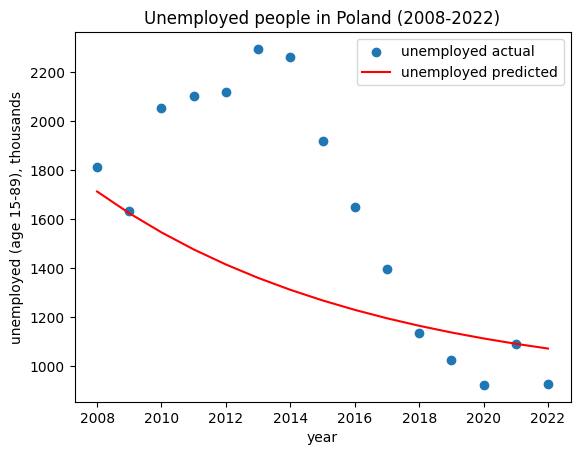

In [110]:
from cProfile import label


plt.scatter(data['year'], data['unemployed, thousands'], label='unemployed actual')
plt.xlabel('year')
plt.ylabel('unemployed (age 15-89), thousands')
plt.title('Unemployed people in Poland (2008-2022)') 
plt.plot(t, U_pred, color='red', label = 'unemployed predicted')
plt.legend()


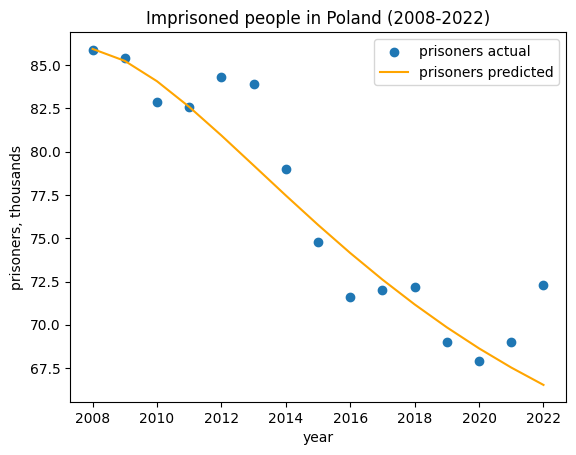

In [111]:
plt.scatter(data['year'], data['prisoners, thousands'], label='prisoners actual')
plt.title('Imprisoned people in Poland (2008-2022)')
plt.xlabel('year')
plt.ylabel('prisoners, thousands')
plt.plot(t, P_pred, color='orange', label = 'prisoners predicted')
plt.legend()


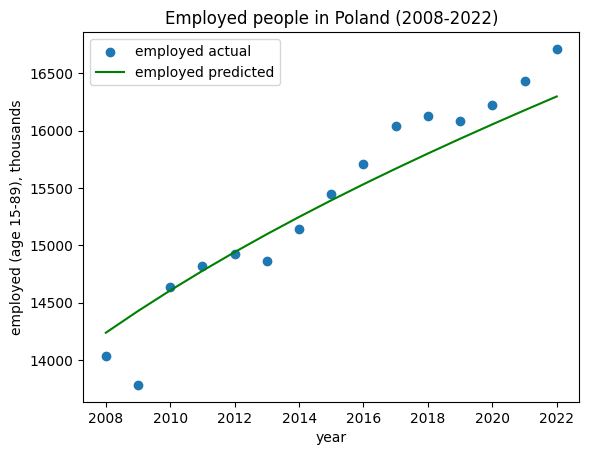

In [112]:
plt.scatter(data['year'], data['employed, thousands'], label='employed actual')
plt.title('Employed people in Poland (2008-2022)')
plt.xlabel('year')
plt.ylabel('employed (age 15-89), thousands')
plt.plot(t, E_pred, color='green', label = 'employed predicted')
plt.legend()
